In [1]:
import os
import xarray as xr
import rioxarray as riox

In [2]:
from dask.distributed import LocalCluster
cluster = LocalCluster()          # Fully-featured local Dask cluster
client = cluster.get_client()
client

/project/cper_neon_aop/conda_envs/py_seg_env/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36243 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36243/status,
Dashboard: http://127.0.0.1:36243/status,Workers: 8
Total threads: 32,Total memory: 240.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45631,Workers: 8
Dashboard: http://127.0.0.1:36243/status,Total threads: 32
Started: Just now,Total memory: 240.19 GiB
Comm: tcp://127.0.0.1:36927,Total threads: 4
Dashboard: http://127.0.0.1:40933/status,Memory: 30.02 GiB
Nanny: tcp://127.0.0.1:46351,


In [3]:
from xrspatial import convolution, focal

/project/cper_neon_aop/conda_envs/py_seg_env/lib/python3.10/site-packages/rapids_dask_dependency/dask_loader.py:36: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 8.0.1. Please consider upgrading.
  return importlib.import_module(spec.name)


In [4]:
xr_veg = riox.open_rasterio('/90daydata/cper_neon_aop/cper_hls_veg_models/data/neon_cper/neon_class_2017_v18_maj3.tif',
                            chunks={'band': -1, 'y': 250, 'x':250}).squeeze()


In [5]:
from scipy.signal import convolve2d

def pf_func(binary, fws, shape='circle'):
    # density function
    if shape == 'circle':
        w_pf = convolution.circle_kernel(1, 1, radius=np.ceil(fws/2))
    else:
        w_pf = np.ones((fws, fws))
    return convolve2d(binary, w_pf, 'same') / fws**2


def pff_calc(binary, fws):
    s = int((fws - 1) / 2)
    ff_pairs = []
    nf_pairs = []
    for j in range(-s, s + 1):
        for i in range(-s, s):
            ff_pairs.append(binary[i, j] and binary[i+1, j])
            nf_pairs.append(binary[i, j] or binary[i+1, j])
    for i in range(-s, s + 1):
        for j in range(-s, s):
            ff_pairs.append(binary[i, j] and binary[i, j+1])
            nf_pairs.append(binary[i, j] or binary[i, j+1])
    if sum([int(x) for x in nf_pairs]) == 0:
        pff = 0
    else:
        pff = sum([int(x) for x in ff_pairs]) / sum([int(x) for x in nf_pairs])
    return pff


def pff_func(binary, fws, pad_method='edge'):
    #connectivity function
    s = int((fws - 1) / 2)
    arr_out = np.ones_like(binary) * np.nan
    binary_pad = np.pad(binary, fws, pad_method)
    for nr in tqdm(range(fws-1, binary.shape[0] + fws)):
        for nc in range(fws-1, binary.shape[1] + fws):
            rs = nr - s
            if rs < 0:
                rs = nr
            rf = rs + fws
            if rf > binary_pad.shape[0]:
                rf = nr
                rs = nr - fws
            cs = nc - s
            if cs < 0:
                cs = nc
            cf = cs + fws
            if cf > binary_pad.shape[1]:
                cf = nc
                cs = cf - fws
            #print(rs, rf, cs, cf)
            arr_tmp = binary_pad[rs:rf, cs:cf]
            if np.all(arr_tmp == 0):
                arr_out[nr - fws, nc - fws] = 0
            else:
                arr_out[nr - fws, nc - fws] = pff_calc(arr_tmp, fws)
    return arr_out
#def pff_func(binary, fws):
#    np.vectorize()

def frag_index(binary, pf, pff, shape='circle', fws=None, cutoff_dict=None):
    # set correction factor to account for whether a circular window was used to calculate density
    if shape=='circle' and fws is not None:
        corr_fact = np.sum(convolution.circle_kernel(1, 1, radius=np.ceil(fws/2))) / np.sum(np.ones((fws, fws)))
    elif shape=='circle' and fws is None:
        print('ERROR: circular kernel set but no window size specified. This is not allowed.')
    else:
        corr_fact = 1.0
    
    arr_out = np.ones_like(binary) * np.nan

    # define Core
    arr_out[(pf >= 0.90*corr_fact)] = 1

    # define Perforated Core
    arr_out[(pf >= 0.60*corr_fact) & (pf < 0.90*corr_fact) & 
            (pf >= pff*corr_fact)] = 2

    # define Edge
    arr_out[(pf >= 0.60*corr_fact) & (pf < 0.90*corr_fact) & 
            (pf < pff*corr_fact)] = 4

    # define Transition
    arr_out[(pf >= 0.40*corr_fact) & (pf < 0.60*corr_fact)] = 5

    # definte Non-colony
    arr_out[(binary != 0) & (pf < 0.40*corr_fact)] = 7 
    
    return arr_out

In [6]:
xr_veg

<xarray.DataArray (y: 13092, x: 12050)>
dask.array<getitem, shape=(13092, 12050), dtype=int16, chunksize=(250, 250), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 5.166e+05 5.166e+05 ... 5.287e+05 5.287e+05
  * y            (y) float64 4.526e+06 4.526e+06 ... 4.513e+06 4.513e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -999
    scale_factor:   1.0
    add_offset:     0.0

In [7]:
from skimage.filters.rank import majority
from scipy.ndimage import binary_fill_holes

In [25]:
from rasterio.plot import show
import numpy as np
from tqdm.notebook import tqdm
import rasterio as rio

In [28]:
rio.enums.Resampling(13)

<Resampling.sum: 13>

In [9]:
crs_epsg = xr_veg.rio.crs.to_epsg()

In [23]:
xr_shrub = (xr_veg==9).astype('int')

In [30]:
xr_shrub_5m = xr_shrub.rio.reproject(xr_veg.rio.crs, 
                                     resolution=[5,5], 
                                     resampling=rio.enums.Resampling(13),
                                     nodata=-999)

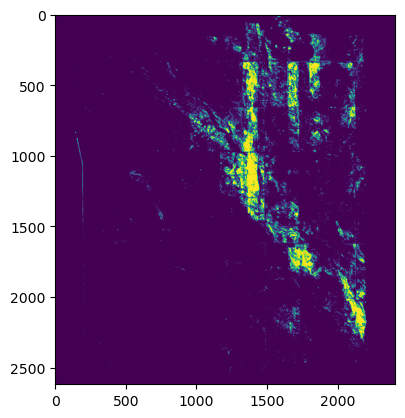

<AxesSubplot:>

In [36]:
show((xr_shrub_5m>5).data)

In [15]:
#show(xr_veg.data)

In [16]:
#show((xr_veg==9).data)

In [113]:
pts_thresh = 1.0  #burrow pts required within radius_m to be part of a colony
win_size = 11  #window size (in pixels) for connectivity calculations

In [114]:
arr_pf = pf_func((xr_shrub_5m >= pts_thresh).data.astype('int'), win_size, 'circle')

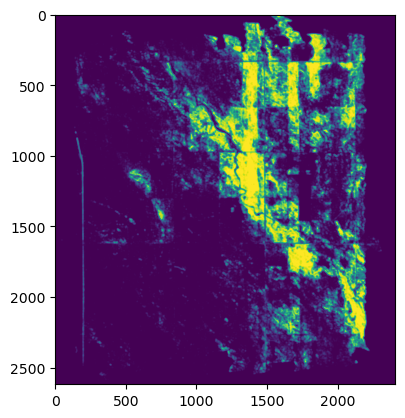

<AxesSubplot:>

In [115]:
show(arr_pf)

In [116]:
arr_pff = pff_func((xr_shrub_5m >= pts_thresh).data.astype('int'), win_size)

  0%|          | 0/2620 [00:00<?, ?it/s]

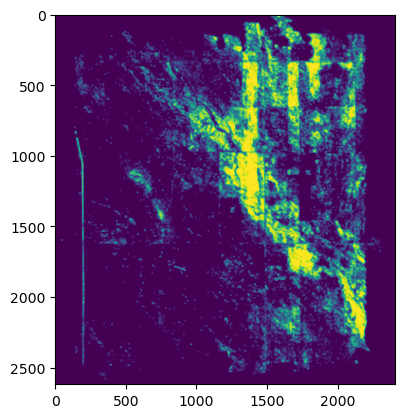

<AxesSubplot:>

In [117]:
show(arr_pff)

In [118]:
arr_conn = frag_index((xr_shrub_5m >= pts_thresh).data.astype('int'), 
                      arr_pf, arr_pff, 'circle', win_size).astype('uint8')

/local/scratch/sean.kearney/16107206/ipykernel_3378765/3551780986.py:2: RuntimeWarning: invalid value encountered in cast
  arr_pf, arr_pff, 'circle', win_size).astype('uint8')


In [119]:
cleanup_kernel = convolution.circle_kernel(1, 1, radius=2)
arr_conn = majority(arr_conn, footprint=cleanup_kernel)

# define cells surrounded by Core or Perforated Core (Core)
arr_core = np.isin(arr_conn, [1, 2]).astype('int')
arr_core_filled = binary_fill_holes(arr_core)
arr_conn[(arr_core_filled == 1) & (arr_core==0)] = 3

# define cells surrounded by Transition, Core and Perforated Core (Transition)
arr_possible = np.isin(arr_conn, [1, 2, 4, 5]).astype('int')
arr_possible_filled = binary_fill_holes(arr_possible)
arr_conn[(arr_possible_filled == 1) & (arr_possible==0) & np.isin(arr_conn, [0, 7])] = 6

xr_conn = xr.DataArray(arr_conn,
                       coords=(xr_shrub_5m.y, xr_shrub_5m.x),
                       dims=('y', 'x'))
xr_conn = xr_conn.rio.write_crs(crs_epsg)

xr_pf = xr.DataArray(arr_pf,
                       coords=(xr_shrub_5m.y, xr_shrub_5m.x),
                       dims=('y', 'x'))
xr_pf = xr_pf.rio.write_crs(crs_epsg)

xr_pff = xr.DataArray(arr_pff,
                       coords=(xr_shrub_5m.y, xr_shrub_5m.x),
                       dims=('y', 'x'))
xr_pff = xr_pff.rio.write_crs(crs_epsg)


In [120]:
xr_conn = xr_conn.astype('uint8')
#xr_conn.rio.to_raster(os.path.join(inDIR, '_'.join([aoi_prefix, flight_prefix, 'burrow_connectivity_25m_5bur_' + str(win_size) + 'px.tif'])))

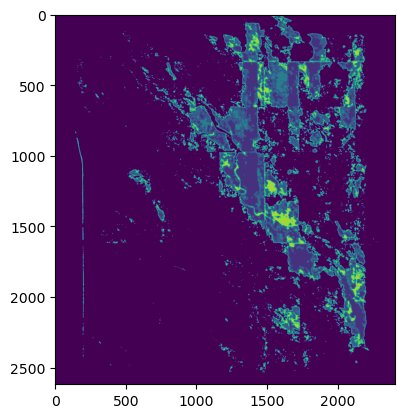

<AxesSubplot:>

In [121]:
show(xr_conn.data)

In [122]:
from skimage.measure import label, regionprops

In [123]:
xr_col_binary = xr_conn.isin([1, 2, 3, 4, 5, 6]).astype('uint8')
col_labels = label(xr_col_binary)
col_regions = regionprops(col_labels)
small_cols = []
for r in col_regions:
    if r.area*xr_conn.rio.resolution()[0]**2*0.00024711 < 1.0:
        small_cols.append(r.label)

In [124]:
xr_col_labels = xr.DataArray(data=col_labels, coords=xr_col_binary.coords)
xr_col_nosmall = xr_col_binary.where(~xr_col_labels.isin(small_cols), other=0)

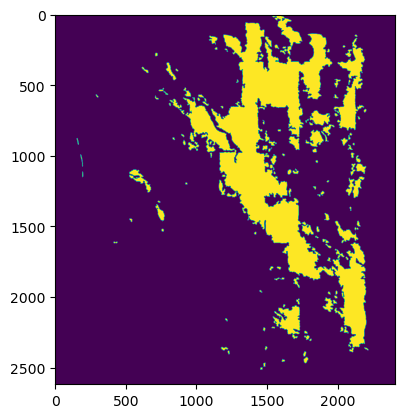

<AxesSubplot:>

In [125]:
show(xr_col_nosmall.data)

In [126]:
from rasterio.features import shapes
from shapely.geometry import shape
import geopandas as gpd

In [128]:
results = (
    {'properties': {'raster_val': v}, 'geometry': s}
    for i, (s, v) 
    in enumerate(
        shapes(xr_col_nosmall.data, mask=None, transform=xr_col_nosmall.rio.transform())))

In [129]:
geoms = list(results)

In [130]:
gpd_col_nosmall  = gpd.GeoDataFrame.from_features(geoms)

In [131]:
gpd_col_nosmall = gpd_col_nosmall[gpd_col_nosmall['raster_val']==1]

<AxesSubplot:>

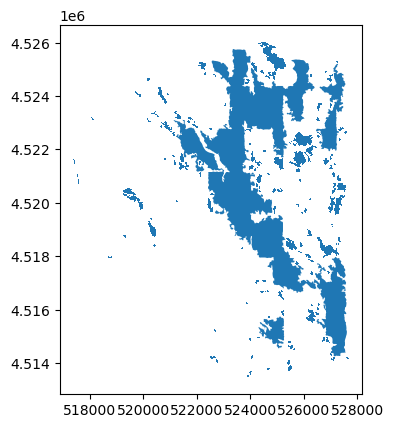

In [132]:
gpd_col_nosmall.plot()

In [133]:
gpd_col_nosmall = gpd_col_nosmall.set_crs(epsg=crs_epsg)

In [134]:
gpd_col_nosmall.to_file('./data/products/shrubs/cper_shrub_zones_5m_gt1ac_1px.shp', crs=crs_epsg)

In [135]:
xr_col_nosmall.rio.to_raster('./data/products/shrubs/cper_shrub_zones_5m_gt1ac_1px.tif')